In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [2]:
def cleanData(filePath, filePathJson, encoding):
    data = pd.read_csv(filePath, encoding=encoding)
    data['trending_date'] = '20' + data['trending_date']
    data['trending_date'] = pd.to_datetime(data['trending_date'],format='%Y.%d.%m')
    categories = pd.read_json(filePathJson)
    catData = json_normalize(categories['items'])
    idToCategories = pd.DataFrame(columns=['category_id', 'category'])
    idToCategories['category_id'] = catData['id']
    idToCategories['category'] = catData['snippet.title']
    idToCategories['category_id'] = idToCategories['category_id'].astype('int64')
    myData = pd.merge(data, idToCategories)
    myData = myData.drop(columns='category_id')
    myData['tags'] = myData.tags.str.strip().str.lower().str.replace('"','').str.replace('|',',')
    myData = myData.drop_duplicates()
    return myData

In [3]:
us = cleanData('../Data/Youtube/USvideos.csv', '../Data/Youtube/US_category_id.json', "latin_1")
mx = cleanData('../Data/Youtube/MXvideos.csv', '../Data/Youtube/MX_category_id.json', "latin_1")
ca = cleanData('../Data/Youtube/CAvideos.csv', '../Data/Youtube/CA_category_id.json', "latin_1")
de = cleanData('../Data/Youtube/DEvideos.csv', '../Data/Youtube/DE_category_id.json', "latin_1")
gb = cleanData('../Data/Youtube/GBvideos.csv', '../Data/Youtube/GB_category_id.json', "latin_1")
ind = cleanData('../Data/Youtube/INvideos.csv', '../Data/Youtube/IN_category_id.json', "latin_1")

In [4]:
us.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13T17:13:01.000Z,shantell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21T06:47:32.000Z,"cute,cats,thai,eggs",98966,2486,184,532,https://i.ytimg.com/vi/0mlNzVSJrT0/default.jpg,False,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11T15:00:03.000Z,"shawn johnson,andrew east,shawn east,shawn and...",321053,4451,1772,895,https://i.ytimg.com/vi/STI2fI7sKMo/default.jpg,False,False,False,Subscribe for weekly videos â¶ http://bit.ly/...,People & Blogs


In [16]:
us_data = us[['category', 'title', 'description']].copy()
us_data['group'] = us_data.groupby('category').grouper.group_info[0] + 1
us_data = us_data.drop_duplicates()
mx_data = mx[['category', 'title', 'description']].copy()
mx_data['group'] = mx_data.groupby('category').grouper.group_info[0] + 1
mx_data = mx_data.drop_duplicates()
ca_data = ca[['category', 'title', 'description']].copy()
ca_data['group'] = ca_data.groupby('category').grouper.group_info[0] + 1
ca_data = ca_data.drop_duplicates()
de_data = de[['category', 'title', 'description']].copy()
de_data['group'] = de_data.groupby('category').grouper.group_info[0] + 1
de_data = de_data.drop_duplicates()
gb_data = gb[['category', 'title', 'description']].copy()
gb_data['group'] = gb_data.groupby('category').grouper.group_info[0] + 1
gb_data = gb_data.drop_duplicates()
ind_data = ind[['category', 'title', 'description']].copy()
ind_data['group'] = ind_data.groupby('category').grouper.group_info[0] + 1
ind_data = ind_data.drop_duplicates()

In [26]:
data = us[['category', 'title', 'description']].copy().append(mx[['category', 'title', 'description']].copy(), ignore_index = True).append(ca[['category', 'title', 'description']].copy(), ignore_index = True).append(de[['category', 'title', 'description']].copy(), ignore_index = True).append(gb[['category', 'title', 'description']].copy(), ignore_index = True).append(ind[['category', 'title', 'description']].copy(), ignore_index = True) 
data['group'] = data.groupby('category').grouper.group_info[0] + 1
data = data.drop_duplicates()

# Video Title 

In [27]:
Vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1,1))
tfidf = Vectorizer.fit_transform(data.title)
vocab = pd.Series(Vectorizer.get_feature_names())
imp_words = pd.Series(np.asarray(tfidf.sum(axis=0).flatten(0))[0], index=vocab)
imp_words.sort_values(ascending=False).head()

2018    2067.013517
¾à      1641.240684
la      1183.660428
en      1015.863986
²à       987.359613
dtype: float64

In [29]:
parameters = {'alpha': np.arange(10)}
NBayes = MultinomialNB()
NBayesCV = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV.fit(tfidf, data['group'])
NBayesCV.best_params_

/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting a

{'alpha': 0}

In [30]:
error_NBayes = 1 - NBayesCV.best_score_
error_NBayes.round(2)

0.58

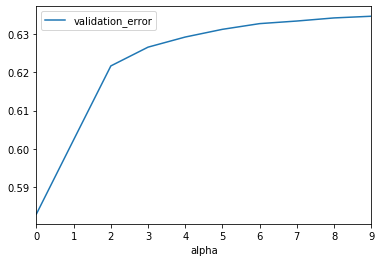

In [31]:
error_plot = pd.DataFrame()
error_plot['alpha'] = parameters['alpha']
error_plot['validation_error'] = 1- NBayesCV.cv_results_['mean_test_score']
error_plot.plot.line(x='alpha',y='validation_error')

In [32]:
1- NBayesCV.cv_results_['mean_train_score'].max()

0.10473789164145819

# KMeans Clustering

In [35]:
df =  us.append(mx, ignore_index = True).append(ca, ignore_index = True).append(de, ignore_index = True).append(gb, ignore_index = True).append(ind, ignore_index = True)
df['Liked_Disliked'] = df['likes'] - df['dislikes']
df['Liked_Disliked'] = (df['Liked_Disliked'] - df['Liked_Disliked'].mean())/df['Liked_Disliked'].std()

In [37]:
df_kmeans = pd.DataFrame()
df_kmeans['X'] = df['views']
df_kmeans['Y'] = df['Liked_Disliked']

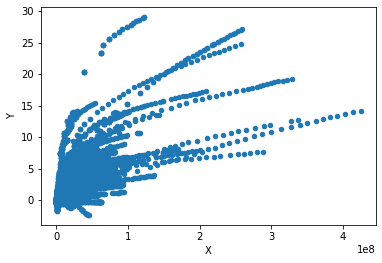

In [39]:
df_kmeans.plot.scatter(x='X', y='Y')

In [40]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(df_kmeans))

In [41]:
centroids = pd.DataFrame(kmeans.cluster_centers_)

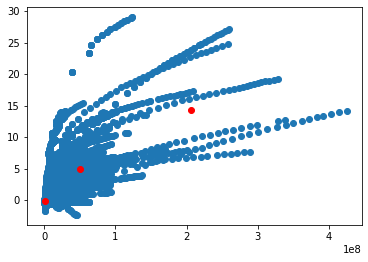

In [42]:
plt.scatter(df_kmeans['X'], df_kmeans['Y'])
plt.scatter(centroids[0],centroids[1],c='red')

In [48]:
labels = kmeans.predict(df_kmeans.values)
colors = np.array(['blue','green','yellow'])
df2 = df_kmeans.copy()
df2['cluster'] = colors[labels]

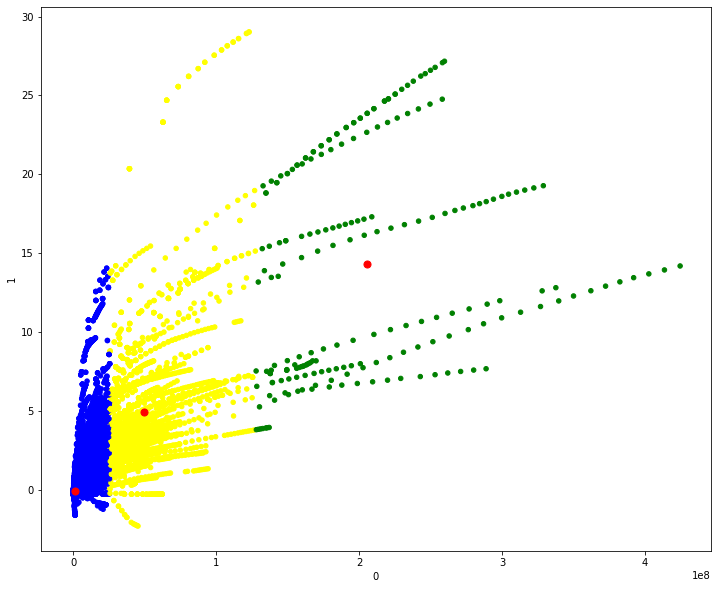

In [51]:
plot1 = df2.plot.scatter(x='X',y='Y',c=df2.cluster.values,figsize=(12,10))
centroids.plot.scatter(x=0,y=1,c='red',s=50,ax=plot1)